In [1]:
import shap
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from classification_utils import *

/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/DataMining/Data_Mining_22_23/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data.head()

,name,lang,bot,created_at,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76,62.340909,14.015152,0.000000,0.272727,0.098485,0.0,0.0,0.037879,0.190903,0.232481,0.037879,0.190903
2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54,69.082645,15.041322,0.000000,0.338843,0.024793,0.0,0.0,0.049587,0.217090,0.284639,0.024793,0.155495
137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,53,65.340909,14.694444,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50,86.944871,18.689463,0.022331,0.006281,0.072575,0.0,0.0,0.165387,0.530838,0.669155,0.826239,13.034008
2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085,72.311246,14.582073,0.000825,0.506461,0.118229,0.0,0.0,0.056365,0.243387,0.317182,0.016772,0.142619


In [4]:
#a descrption of the dataset
data.describe()

,bot,statuses_count,avg_length,avg_special_chars,urls_ratio,mentions_ratio,hashtags_ratio,reply_count_mean,reply_count_std,favorite_count_mean,favorite_count_std,favorite_count_entropy,retweet_count_mean,retweet_count_std
count,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000,11508.000000
mean,0.531456,5148.794751,67.100135,15.045892,0.031045,0.329076,0.088484,0.001967,0.023941,0.084281,0.365536,0.385427,1.357545,14.574041
std,0.499031,18496.606420,12.755296,2.454106,0.053379,0.315589,0.070828,0.007796,0.068508,0.109621,0.408358,0.390777,2.827068,23.390000
min,0.000000,0.000000,32.500000,9.644166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,59.686796,13.553296,0.000000,0.010260,0.045455,0.000000,0.000000,0.017751,0.136692,0.119116,0.010526,0.104251
50%,1.000000,57.000000,65.340909,14.694444,0.005109,0.300971,0.070423,0.000000,0.000000,0.045752,0.230747,0.268594,0.043478,0.238606
75%,1.000000,2041.000000,74.254999,16.772205,0.037445,0.450781,0.113295,0.000000,0.000000,0.088862,0.451218,0.491767,0.949402,24.144412
max,1.000000,399555.000000,104.449541,22.000000,0.287760,1.210354,0.337268,0.044444,0.333767,0.529903,2.183383,1.723913,12.902439,198.461303


In [5]:
data = data.join(pd.get_dummies(data["lang"]))

In [6]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['created_at', 'statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


In [7]:
# to be removed
for lang in data.lang.unique():
    del train_set[lang]
    del test_set[lang]

In [28]:
scaler = StandardScaler()

train_X = scaler.fit_transform(train_set)
test_X = scaler.transform(test_set)

In [9]:
with open("models_checkpoints/svm_no_lang.bin", "rb") as f:
    svm_model = pickle.load(f)

## Explain the results

In [30]:
explainer = shap.KernelExplainer(svm_model.predict, train_X[0:5])

In [31]:
shap_values = explainer.shap_values(test_X[0:20])

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 16/20 [00:10<00:02,  1.64it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [37]:
shap_values.shape

(20, 14)

In [38]:
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

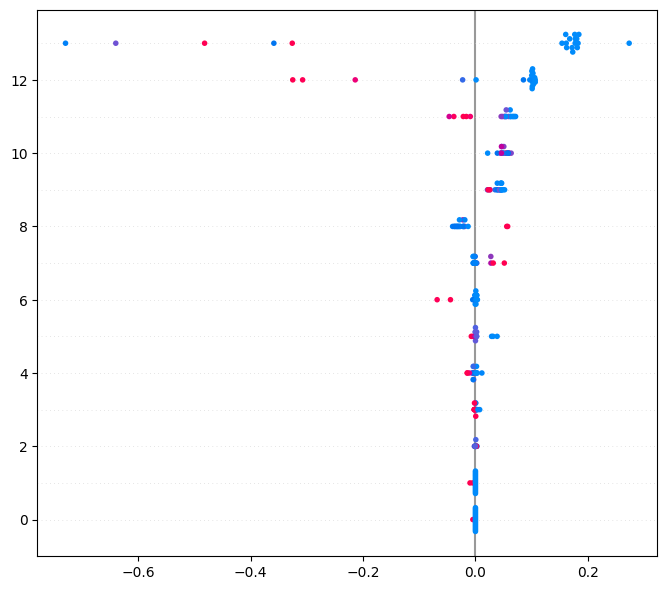

In [40]:
shap.summary_plot(shap_values, test_X[0:20], feature_names=test_set.columns.to_list())

In [17]:
shap.dependence_plot("avg_special_chars", shap_values[0], test_X[0:10], feature_names=test_set.columns.to_list())

TypeError: order must be str, not int

In [18]:
shap_interaction_values = shap.KernelExplainer(wrapper_svm, train_X[0:10]).shap_interaction_values(train_X[0:10])

AttributeError: 'Kernel' object has no attribute 'shap_interaction_values'